## 勾配ブースティング

- 勾配情報を使って、徐々に残差を減らしていく
- 最初F0は平均値
- rib = yi - Fb-1(x)は損失関数の勾配になる　→ この勾配を学習
- (?) 残差 = 勾配という認識で問題ない？　→　式では理解できるけどどんな利点がある？？  
  -> だだ、r = y1 - Fb-1の今までのFを計算するのは大変かも
---

## 勾配ブースティング回帰を実装してみよう

実装すること 
1. クラス作成
2. コンストラクタの作成 =>　引数：学習率、イテレーション数、木の深さ、ランダムシード
3. 学習メソッド　
    - 引数:X, y
    - 初期モデルF_0
    - 各決定技(fb(x))を学習
4. 予測メソッド(predict)を作成
    - 学習済みの決定木f1~b(x)およびF0から最終的な予測値Fbを計算

In [217]:
from sklearn.tree import DecisionTreeRegressor
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

In [5]:
class MyGradientBoosthingregressor:
    def __init__(self, leaning_rate=0.03, n_estimators=100, max_depth=1, random_state=0):
        self.leaning_rate = leaning_rate
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.random_state = random_state
        self.estimators = []
        self.F0 = None
        
        
    # 学習メソッド
    def fit(self, X, y):
        
        #　初期値F0,　更新用のFb 
        self.F0 = np.mean(y)
        Fb = self.F0
        
        
        for _ in range(self.n_estimators):
            
            #インスタンス化
            estimator = DecisionTreeRegressor(max_depth=self.max_depth, random_state=self.random_state)
            
            # 残差
            residual = y - Fb
            
            # 学習 => f値算出 => 全体のF値に加算
            estimator.fit(X, residual)
            weight = estimator.predict(X)
            Fb += self.leaning_rate * weight
            
            # モデルの格納
            self.estimators.append(estimator)

            
    # 予測メソッド
    def predict(self, X):
        
        # 初期値
        Fb = self.F0
        
        # fitで作成したモデル使ってFbを加算していく
        for estimator in self.estimators:
            Fb += self.leaning_rate * estimator.predict(X)
        
        # 限りなく各データのyに近いFbを返す
        return Fb

In [6]:
# 検証用データセット
df = sns.load_dataset('mpg')
df.dropna(inplace=True)
X = df['horsepower'].values.reshape(-1, 1)
y = df['mpg'].values

In [7]:
my_mgbr = MyGradientBoosthingregressor()
my_mgbr.fit(X, y)
a = my_mgbr.predict(X)

In [8]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y, a)

3.202023390242933

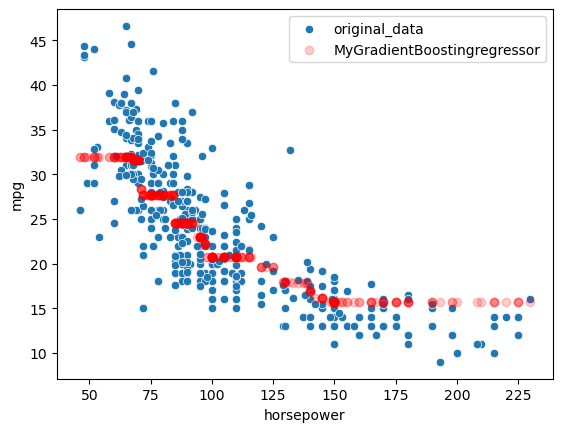

In [9]:
# 線形の確認
sns.scatterplot(data=df, x='horsepower', y='mpg', label='original_data')
plt.scatter(X, a, alpha=0.2, color='r', label='MyGradientBoostingregressor')
plt.legend()

### sklearnのGradientBoosthingRegressorを使う

In [10]:
from sklearn.ensemble import GradientBoostingRegressor
lr = 0.03
gbr = GradientBoostingRegressor(max_depth=1, learning_rate=lr, random_state=0).fit(X, y)

In [11]:
# スクラッチとsklearnの勾配ブースティングの結果比較　＝＞　正しくスクラッチできた。
np.unique(gbr.predict(X) == my_mgbr.predict(X))

array([ True])

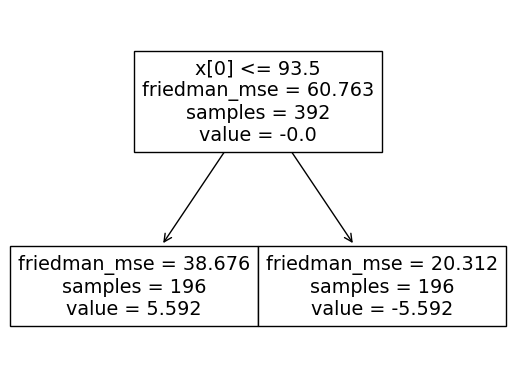

In [12]:
# 先頭モデルを取り出し、決定木を描画
from sklearn.tree import plot_tree
model = gbr.estimators_[0][0]
_ = plot_tree(model)

In [13]:
# 最初のデータで　Fb = F0 + lr*Fb1 + ・・・の式になっているか確認
result_list = []
idx=0
for t in gbr.estimators_:
    result = t[0].predict([X[0]])
    result_list.append(lr*result)

F0 = np.mean(y)
Fb = F0 + np.cumsum(result_list)

Fb[-1]

17.95434839052103

In [14]:
y[0]

18.0

Text(0.5, 1.0, 'cumsum of X[0]data by GBDT')

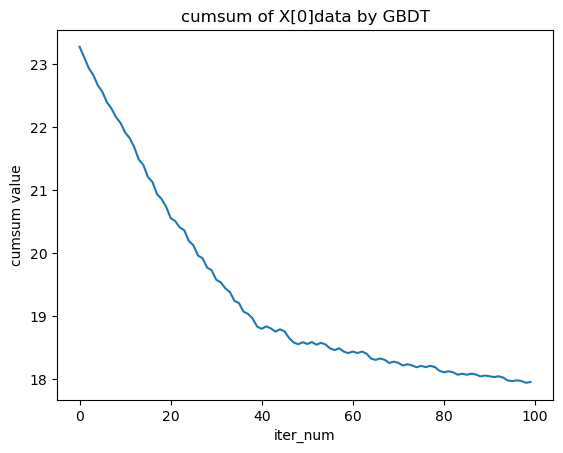

In [15]:
plt.plot(Fb)
plt.xlabel('iter_num')
plt.ylabel('cumsum value')
plt.title('cumsum of X[0]data by GBDT')

## 勾配ブースティング分類を実装してみよう

In [42]:
model = DecisionTreeRegressor(max_depth=1, random_state=0).fit(X, y)

実際に予測したユニークな値：[17.85408163 29.0377551 ]



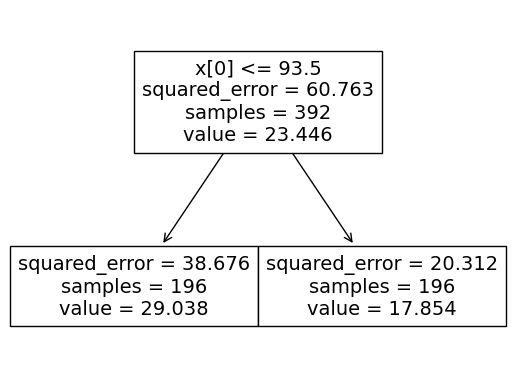

In [28]:
# 条件分岐の描画
#　29.038, 17.854に分かれる
_ = plot_tree(model)

#　検証 
unique_values = np.unique(model.predict(X))
print(f"実際に予測したユニークな値：{unique_values}\n")

In [19]:
#　各分割で割り振られる値
model.tree_.value

array([[[23.44591837]],

       [[29.0377551 ]],

       [[17.85408163]]])

In [44]:
# この値を変更すると割り振られる値が変更する
model.tree_.value[2][0][0] = 3
print(model.tree_.value)
model.predict(X)[:20]

[[[23.44591837]]

 [[29.0377551 ]]

 [[ 3.        ]]]


array([ 3.       ,  3.       ,  3.       ,  3.       ,  3.       ,
        3.       ,  3.       ,  3.       ,  3.       ,  3.       ,
        3.       ,  3.       ,  3.       ,  3.       ,  3.       ,
        3.       ,  3.       , 29.0377551, 29.0377551, 29.0377551])

In [92]:
# 割り振る値をラベルにする方法
div_class = model.apply(X)
div_class

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1,
       2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2,
       1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2,
       1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2,
       1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2,
       1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,

In [100]:
sum_1 = np.sum(div_class==1)
sum_2 = np.sum(div_class==2)
overall = len(div_class)
print(sum_1, sum_2, overall)

196 196 392


In [159]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

# データのロード
df = sns.load_dataset('titanic')
df.dropna(inplace=True)


# x, yの準備
X = df.loc[:, (df.columns != 'survived') & (df.columns != 'alive')]
y = df['survived']


# ラベルエンコーディング
from sklearn.preprocessing import OrdinalEncoder
oe = OrdinalEncoder()


# defaultはnp.arrayで返るので、pdで返るようにする
oe.set_output(transform='pandas')


# カテゴリカルデータの選択 => label encoding
cat_cols = X.select_dtypes(exclude=np.number).columns.to_numpy()
X.loc[:, cat_cols] = oe.fit_transform(X[cat_cols])
# X = oe.fit_transform(X)


# hold-out
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

/tmp/ipykernel_38/3353368784.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:, cat_cols] = oe.fit_transform(X[cat_cols])


In [219]:
class MyGradientBoostingClassifier:
    def __init__(self, leaning_rate=0.03, n_estimators=100, max_depth=1, random_state=0):
        self.leaning_rate = leaning_rate
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.random_state = random_state
        self.estimators = []
        
        
    # 学習メソッド
    def fit(self, X, y):
        
        #　オッズ比F0,　更新用のFb
        self.F0 = np.log(y.mean() / (1 - y.mean()))
        F0 = np.full(len(y), self.F0) #ベクトル化
        Fb = F0
        
        # n_estimators分モデル作成
        for _ in range(self.n_estimators):    
            # シグモイド関数に注意
            p = 1 / (1 + np.exp(-Fb))
            r = y - p
            
            #学習、推論、モデルの格納 -> rは連続血なのでモデルは回帰の決定木を使用！！！！
            estimator = DecisionTreeRegressor(max_depth=self.max_depth, random_state=self.random_state)
            estimator.fit(X, r)
            X_leafs = estimator.apply(X)
            leaf_ids = np.unique(X_leafs)
            for leaf_id in leaf_ids:
                # 弱学習器の出力の値を計算
                fltr = X_leafs == leaf_id
                num = r[fltr].sum()
                den = (p[fltr]*(1-p[fltr])).sum()
                estimator_pred_proba = num / den
                
                # 弱学習きの出力に上書き => estimator.predictの出力のため
                estimator.tree_.value[leaf_id, 0, 0] = estimator_pred_proba
                # 当該データのFbを計算
                Fb[fltr] += self.leaning_rate * estimator_pred_proba
            self.estimators.append(estimator)
            
            
    def predict_proba(self, X):
        Fb = np.full(X.shape[0], self.F0)
        
        # モデルごとの推測
        for estimator in self.estimators:
            Fb += self.leaning_rate * estimator.predict(X)
            
        return 1 / (1 + np.exp(-Fb))

In [220]:
my_gbc = MyGradientBoostingClassifier(n_estimators=100, max_depth=1)
my_gbc.fit(X_train, y_train)
my_gbc.predict_proba(X_test)

array([0.5514342 , 0.4329777 , 0.80125347, 0.80125347, 0.5514342 ,
       0.25797762, 0.5514342 , 0.83715418, 0.88099514, 0.88099514,
       0.5514342 , 0.82137752, 0.82137752, 0.88099514, 0.5514342 ,
       0.5514342 , 0.5514342 , 0.82137752, 0.88099514, 0.40100637,
       0.88099514, 0.78760146, 0.88099514, 0.88099514, 0.80125347,
       0.5514342 , 0.40100637, 0.80125347, 0.4329777 , 0.4329777 ,
       0.4329777 , 0.88099514, 0.88099514, 0.88099514, 0.82137752,
       0.88099514, 0.82137752, 0.88099514, 0.40100637, 0.5514342 ,
       0.4329777 , 0.82137752, 0.5514342 , 0.78760146, 0.40100637,
       0.88099514, 0.88099514, 0.5514342 , 0.5514342 , 0.5514342 ,
       0.5514342 , 0.82137752, 0.5514342 , 0.88099514, 0.88099514])

## sklearnのGradientBoostingClassifierを使う

In [216]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.03, max_depth=1, random_state=0).fit(X_train, y_train)
gbc.predict_proba(X_test)[:, 1]

array([0.5514342 , 0.4329777 , 0.80125347, 0.80125347, 0.5514342 ,
       0.25797762, 0.5514342 , 0.83715418, 0.88099514, 0.88099514,
       0.5514342 , 0.82137752, 0.82137752, 0.88099514, 0.5514342 ,
       0.5514342 , 0.5514342 , 0.82137752, 0.88099514, 0.40100637,
       0.88099514, 0.78760146, 0.88099514, 0.88099514, 0.80125347,
       0.5514342 , 0.40100637, 0.80125347, 0.4329777 , 0.4329777 ,
       0.4329777 , 0.88099514, 0.88099514, 0.88099514, 0.82137752,
       0.88099514, 0.82137752, 0.88099514, 0.40100637, 0.5514342 ,
       0.4329777 , 0.82137752, 0.5514342 , 0.78760146, 0.40100637,
       0.88099514, 0.88099514, 0.5514342 , 0.5514342 , 0.5514342 ,
       0.5514342 , 0.82137752, 0.5514342 , 0.88099514, 0.88099514])

In [218]:
print(f"grad boost AUC:{roc_auc_score(y_test, gbc.predict_proba(X_test)[:, 1])}")

grad boost AUC:0.9407051282051282


In [255]:
#　Fbの正確さの検討
results=[]
for t in gbc.estimators_:
    result = 0.03 * t[0].predict([X_test.iloc[0]])
    results.append(result)

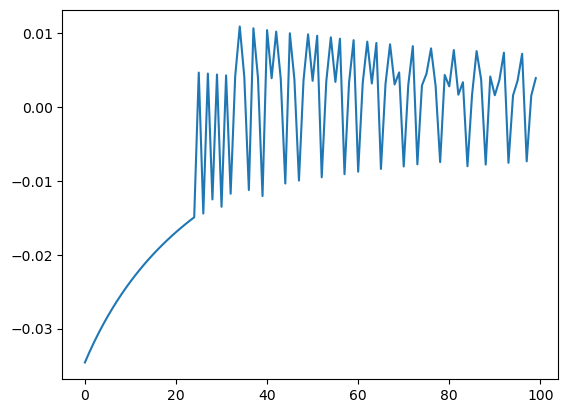

In [256]:
plt.plot(results)

In [272]:
F_0 = np.log(y_train.mean() / (1 - y_train.mean()))
Fb = np.cumsum(results)[-1] + F_0
predict = 1 / (1 + np.exp(-Fb))

In [273]:
predict

0.551434197251246

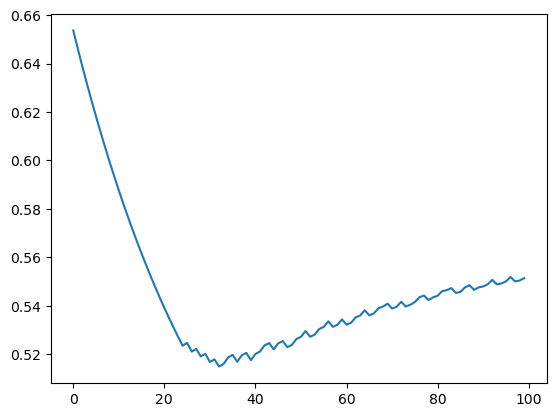

In [274]:
Fb = np.cumsum(results) + F_0
predict = 1 / (1 + np.exp(-Fb))
plt.plot(predict)